In [1]:
!python --version

Python 3.10.16


In [1]:
import binascii, os, sys
import datetime as dt

import numpy as np
import pandas as pd

import pymses
from pymses.utils import constants as C
from pymses.filters import CellsToPoints


import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import patches
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import to_rgb, to_rgba

In [3]:
print(np.__version__)

1.26.4


In [4]:
dust_to_gas = 0.01

au    = 1.49598e13         # Astronomical Unit         [cm]
pc    = 3.08572e18         # Parsec                    [cm]
ms    = 1.98892e33         # Solar mass                [g]
ts    = 5.78e3             # Solar temperature         [K]
ls    = 3.8525e33          # Solar luminosity          [erg/s]
rs    = 6.96e10            # Solar radius              [cm]
sigma = 5.670374419e-5     # Stefan–Boltzmann constant [cgs]
c     = 2.99792458e10      # Speed of light            [cm/s]
#
# Unit conversion:
#
pc2cm   = 3.085677581e18
pc2m    = 3.085677581e16
au2cm   = 1.495978707e13
au2m = 1.4959787070e11
cgs2jy  = 1e23             # Convert from CGS to Jy/px

# OcTree Class

In [5]:
class cell_oct:
    """written by Stefan Reiss"""
    def __init__(self, _x_min, _y_min, _z_min, _length, _level):
        self.x_min = _x_min
        self.y_min = _y_min
        self.z_min = _z_min
        
        self.length = _length
        self.level = _level
    
        self.isleaf = 0
        self.data = []
        self.branches = []  
                  
class OcTree:
    """written by Stefan Reiss"""
    def __init__(self, _x_min, _y_min, _z_min, _length):
        self.root = cell_oct(_x_min, _y_min, _z_min, _length, 0)

    def initCellBoundaries(self, cell,_level):
        x_min = cell.x_min
        y_min = cell.y_min
        z_min = cell.z_min
        l = 0.5 * cell.length

        level = _level

        cell.isleaf = 0
        cell.data = []
        cell.branches = [None, None, None, None, None, None, None, None]
        cell.branches[0] = cell_oct(x_min, y_min, z_min, l, level)
        cell.branches[1] = cell_oct(x_min + l, y_min, z_min, l, level)
        cell.branches[2] = cell_oct(x_min, y_min + l, z_min, l, level)
        cell.branches[3] = cell_oct(x_min + l, y_min + l, z_min, l, level)

        cell.branches[4] = cell_oct(x_min, y_min, z_min + l, l, level)
        cell.branches[5] = cell_oct(x_min + l, y_min, z_min + l, l, level)
        cell.branches[6] = cell_oct(x_min, y_min + l, z_min + l, l, level)
        cell.branches[7] = cell_oct(x_min + l, y_min + l, z_min + l, l, level)     
        
    def insertInTree(self, cell_pos, cell, _level):    
        x_pos = cell.x_min
        y_pos = cell.y_min
        z_pos = cell.z_min

        if cell_pos.level == cell.level:
            cell_pos.data=cell.data
            cell_pos.isleaf=1
                        
        else:    
            if len(cell_pos.branches)==0:
                self.initCellBoundaries(cell_pos,_level+1)

            x_mid = cell_pos.x_min+0.5*cell_pos.length
            y_mid = cell_pos.y_min+0.5*cell_pos.length
            z_mid = cell_pos.z_min+0.5*cell_pos.length
            
            new_cell_pos = cell_pos

            if(z_pos < z_mid): #z 0 1 2 3

                if(y_pos < y_mid): #y 0 1

                    if(x_pos < x_mid): #x 0
                        new_cell_pos = cell_pos.branches[0]
                    else: #x 1
                        new_cell_pos = cell_pos.branches[1]

                else: #y 2 3

                    if(x_pos < x_mid): #x 2
                        new_cell_pos = cell_pos.branches[2]
                    else: #x 3
                        new_cell_pos = cell_pos.branches[3]


            else: #z 4 5 6 7

                if(y_pos < y_mid): #y 4 5

                    if(x_pos < x_mid): #x 4
                        new_cell_pos = cell_pos.branches[4]
                    else: #x 5
                        new_cell_pos = cell_pos.branches[5]

                else: #y 6 7

                    if(x_pos < x_mid): #x 6
                        new_cell_pos = cell_pos.branches[6]
                    else: #x 7
                        new_cell_pos = cell_pos.branches[7]

            self.insertInTree(new_cell_pos, cell, _level+1)


    def writeOcTree(self, file, cell):
        global cell_counter
        global nr_of_cells

        file.write(struct.pack("H", cell.isleaf))
        file.write(struct.pack("H", cell.level))   

        if cell.isleaf == 1:    
            data_len = len(cell.data)
            
            if cell_counter % 10000 == 0:
                sys.stdout.write('-> Writing octree grid file : ' + str(100.0 * cell_counter / nr_of_cells) + ' %     \r')
                sys.stdout.flush()
                
            cell_counter += 1 
         
            for i in range(0, data_len):
                file.write(struct.pack("f", cell.data[i]))
        else:
            for i in range(8):
                self.writeOcTree(file, cell.branches[i])
                
                
    def checkOcTree(self, cell):
        global cell_counter
        global nr_of_cells

        if cell.isleaf == 1:    
            length = len(cell.data)
            
            if length == 0:
                return False
            
            
            if cell_counter % 10000 == 0:
                sys.stdout.write('-> Checking octree integrity : ' + str(100.0 * cell_counter / nr_of_cells) + ' %     \r')
                sys.stdout.flush()
                
            cell_counter += 1    
            
        else:
            length = len(cell.branches)
            
            if length == 0:
                return False
            
            for i in range(8):
                self.checkOcTree(cell.branches[i])                
                
        return True
                
    def writeOcTree_radmc(self, cell, grid, density):
        global cell_counter
        global nr_of_cells

        if cell.isleaf == 1:    
            data_len = len(cell.data)
            
            if cell_counter % 10000 == 0:
                sys.stdout.write('-> Writing octree grid file : ' + str(100.0 * cell_counter / nr_of_cells) + ' %     \r')
                sys.stdout.flush()
                
            cell_counter += 1
                
            density.append(cell.data[0])

            #temp.append(cell.data[3])

            grid.append(0)

        else:
            grid.append(1)
            
            for i in range(8):
                self.writeOcTree_radmc(cell.branches[i], grid, density)

# LOAD RAMSES DATA

In [13]:
datapath = "/data/pebbles/scratch/"
outnum = str(13).zfill(5)
input_file = datapath+'output_'+outnum
sink_filename = datapath+'output_'+outnum+'/sink_'+outnum+'.csv'

output_path = '/nfs/pic.es/user/s/sgavino/enygma/examples/maxime_model/radmc3d/output_'+str(outnum)+'/'

In [14]:
CLR_LINE =   "                                                      \r"

In [15]:
global cell_counter
cell_counter = 0

In [16]:
print ("Ramses input:    ", input_file)
print ("Output for RADMC: amr_grid.inp, dust_density.inp")
print ("")
print ("Loading RAMSES data from: \n", input_file)

Ramses input:     /data/pebbles/scratch/output_00013
Output for RADMC: amr_grid.inp, dust_density.inp

Loading RAMSES data from: 
 /data/pebbles/scratch/output_00013


In [17]:
outstr = "output_"
outloc = input_file.rfind(outstr) #number of characters before /output_
folder = input_file[:outloc] #just the path to output_/
numloc = outloc+len(outstr) #total number of characters in output_ path

In [18]:
num = int(input_file[numloc:numloc+5])
input_file

'/data/pebbles/scratch/output_00013'

In [19]:
snap = pymses.RamsesOutput(folder,num)

  -> Found 3 namelist files (*.nml)
  -> Checking endianness for output #13...
  -> Computing hilbert minimal domain description for output #13...


In [20]:
snap.amr_fields()

AmrDataFileFieldDescriptor : [RamsesAmrScalar(name = "rho", ivar = 0, file = "hydro"),
RamsesAmrScalar(name = "dustratio1", ivar = 11, file = "hydro"),
RamsesAmrScalar(name = "dustratio2", ivar = 12, file = "hydro"),
RamsesAmrScalar(name = "dustratio3", ivar = 13, file = "hydro"),
RamsesAmrScalar(name = "dustratio4", ivar = 14, file = "hydro"),
RamsesAmrScalar(name = "dustratio5", ivar = 15, file = "hydro"),
RamsesAmrScalar(name = "dustratio6", ivar = 16, file = "hydro"),
RamsesAmrScalar(name = "dustratio7", ivar = 17, file = "hydro"),
RamsesAmrScalar(name = "dustratio8", ivar = 18, file = "hydro"),
RamsesAmrScalar(name = "dustratio9", ivar = 19, file = "hydro"),
RamsesAmrScalar(name = "dustratio10", ivar = 20, file = "hydro"),
RamsesAmrVector(name = "vel", ivars = [1, 2, 3], file = "hydro"),
RamsesAmrVector(name = "Bl", ivars = [4, 5, 6], file = "hydro"),
RamsesAmrVector(name = "Br", ivars = [7, 8, 9], file = "hydro"),
RamsesAmrScalar(name = "P", ivar = 10, file = "hydro"),
RamsesAmrM

In [21]:
amr = snap.amr_source(["rho","dustratio1", "dustratio2", "dustratio3", "dustratio4", "dustratio5", "dustratio6", "dustratio7", "dustratio8", "dustratio9", "dustratio10"])

In [22]:
cell_source = CellsToPoints(amr)
cell_source.ndim

3

In [23]:
cells = cell_source.flatten()

Reading amr data  : /data/pebbles/scratch/output_00013/amr_00013.out00001
Reading hydro     : /data/pebbles/scratch/output_00013/hydro_00013.out00001
Reading amr data  : /data/pebbles/scratch/output_00013/amr_00013.out00002
Reading hydro     : /data/pebbles/scratch/output_00013/hydro_00013.out00002
Reading amr data  : /data/pebbles/scratch/output_00013/amr_00013.out00003
Reading hydro     : /data/pebbles/scratch/output_00013/hydro_00013.out00003
Reading amr data  : /data/pebbles/scratch/output_00013/amr_00013.out00004
Reading hydro     : /data/pebbles/scratch/output_00013/hydro_00013.out00004
Reading amr data  : /data/pebbles/scratch/output_00013/amr_00013.out00005
Reading hydro     : /data/pebbles/scratch/output_00013/hydro_00013.out00005


Reading amr data  : /data/pebbles/scratch/output_00013/amr_00013.out00006
Reading hydro     : /data/pebbles/scratch/output_00013/hydro_00013.out00006
Reading amr data  : /data/pebbles/scratch/output_00013/amr_00013.out00007
Reading hydro     : /data/pebbles/scratch/output_00013/hydro_00013.out00007
Reading amr data  : /data/pebbles/scratch/output_00013/amr_00013.out00008
Reading hydro     : /data/pebbles/scratch/output_00013/hydro_00013.out00008
Reading amr data  : /data/pebbles/scratch/output_00013/amr_00013.out00009
Reading hydro     : /data/pebbles/scratch/output_00013/hydro_00013.out00009
Reading amr data  : /data/pebbles/scratch/output_00013/amr_00013.out00010
Reading hydro     : /data/pebbles/scratch/output_00013/hydro_00013.out00010
Reading amr data  : /data/pebbles/scratch/output_00013/amr_00013.out00011
Reading hydro     : /data/pebbles/scratch/output_00013/hydro_00013.out00011
Reading amr data  : /data/pebbles/scratch/output_00013/amr_00013.out00012
Reading hydro     : /data/

In [24]:
# Now make the output dictionary
# Spatial information
output = {}

In [25]:
# Cell lengths
unit_l = snap.info["unit_length"].express(C.m)
output["dx"] = cells.get_sizes()*unit_l

In [26]:
unit_l

5209956521701593.0

In [27]:
# max. number of cells
nr_of_cells = len(output["dx"])

In [28]:
cells.points[:,0]

array([0.015625  , 0.046875  , 0.015625  , ..., 0.50683594, 0.50488281,
       0.50683594])

In [29]:
# Original cell positions (from 0 to 1) converted into uint length)
output["x"] = cells.points[:,0]*unit_l
output["y"] = cells.points[:,1]*unit_l
output["z"] = cells.points[:,2]*unit_l

In [30]:
print("\nx min max", output["x"].min(), output["x"].max())


x min max 81405570651587.39 5128550951050006.0


In [31]:
# level of each cell
output["level"]=np.log2(unit_l/output["dx"])

In [32]:
# Density in cm^-3
output["dens"]  = cells["rho"]  # m-3     #*snap.info["unit_density"].express(C.g_cc)
print("dens min, max", output["dens"].min(), output["dens"].max())

dens min, max 161.4327193254024 556497762028.974


In [33]:
output["dustratio1"]  = cells["dustratio1"]  # m-3     #*snap.info["unit_density"].express(C.g_cc)
output["dustratio2"]  = cells["dustratio2"]  # m-3     #*snap.info["unit_density"].express(C.g_cc)
output["dustratio3"]  = cells["dustratio3"]  # m-3     #*snap.info["unit_density"].express(C.g_cc)
output["dustratio4"]  = cells["dustratio4"]  # m-3     #*snap.info["unit_density"].express(C.g_cc)
output["dustratio5"]  = cells["dustratio5"]  # m-3     #*snap.info["unit_density"].express(C.g_cc)
output["dustratio6"]  = cells["dustratio6"]  # m-3     #*snap.info["unit_density"].express(C.g_cc)
output["dustratio7"]  = cells["dustratio7"]  # m-3     #*snap.info["unit_density"].express(C.g_cc)
output["dustratio8"]  = cells["dustratio8"]  # m-3     #*snap.info["unit_density"].express(C.g_cc)
output["dustratio9"]  = cells["dustratio9"]  # m-3     #*snap.info["unit_density"].express(C.g_cc)
output["dustratio10"]  = cells["dustratio10"]  # m-3     #*snap.info["unit_density"].express(C.g_cc)

In [34]:
output["dustratio10"]

array([2.28861027e-10, 1.88625503e-10, 4.10051218e-10, ...,
       4.10552992e-10, 3.21764656e-10, 3.99476305e-10])

In [35]:
output["dustratio10"]

array([2.28861027e-10, 1.88625503e-10, 4.10051218e-10, ...,
       4.10552992e-10, 3.21764656e-10, 3.99476305e-10])

In [36]:
# Gas temperature in K
print("*************************************************")
#============================================
# Everything in cgs for the moment:
if 'mu_gas' in snap.info:
    mu=snap.info['mu_gas'] #mass per particles
else:
    mu=1.4
print("WORKING WITH mu_gas = ", mu)

*************************************************
WORKING WITH mu_gas =  2.31


In [37]:
G = 6.7e-8
kbol  =  1.38062e-16   # erg/degre
pc=3.08e18 #cm
mp =  mu * 1.660531e-24  #n gramme
scale_n = 1.
scale_l = pc
scale_d = scale_n*mp
scale_t = 1.0/np.sqrt(G*scale_d)
scale_v = scale_l / scale_t    
scale_T2 = mp/kbol * scale_v**2

In [38]:
#============================================
unit = snap.info["unit_temperature"].express(C.K)
print("unit", unit)
print("scale_T2", scale_T2)
X = 0.76 # Hydrogen mass fraction

unit 0.02917236910296533
scale_T2 0.06773607233773474


In [39]:
#output["Tgas"] = cells["P"]/cells["rho"]*scale_T2
#output["Tdust"] = cells["P"]/cells["rho"]*scale_T2
#print("Min Max Mean T", output["Tgas"].min(), output["Tgas"].max(), output["Tgas"].mean())
#print("*************************************************")

In [40]:
# Velocity in m/s
#output["vel"] = cells["vel"]*snap.info["unit_velocity"].express(C.m/C.s)

In [41]:
# B-field in G
unit_b = snap.info['unit_mag'].express(C.T)
unit_b = unit_b * 8 * np.pi	

In [42]:
output["mass_dens"] = cells["rho"]*mp

# converting into RADMC3D files

In [43]:
L_cm = pymses.RamsesOutput(datapath, num).info["unit_length"].express(C.cm) # box length in cm

  -> Found 3 namelist files (*.nml)
  -> Checking endianness for output #13...
  -> Computing hilbert minimal domain description for output #13...


In [44]:
#
# Transpose center of cube
#
x_min = -0.5*unit_l
y_min = -0.5*unit_l
z_min = -0.5*unit_l

max_level = max(output["level"])
min_level = min(output["level"])

In [45]:
print("\n")
print("Octree parameter:")
print("    Level        (min,max)  : ", int(min_level),",", int(max_level))
print("    Nr. of cells (data, max): ", nr_of_cells,",", 8**max_level)
print("    Length       (min,max)  : ", unit_l/(2**max_level),",", unit_l, "\n")



Octree parameter:
    Level        (min,max)  :  5 , 13
    Nr. of cells (data, max):  516377 , 549755813888.0
    Length       (min,max)  :  635981020715.5265 , 5209956521701593.0 



In [46]:
#
# Init. octree
#
tree = OcTree(x_min, y_min, z_min, unit_l)

In [47]:
size_hole_au = 4
# to add manually for the moment
x,y,z = 0.0794141, 0.0870526, 0.0792167 # from sink.info, corner position x, y, z in pc
boxlen = 0.169154432522779 # from info.txt in pc

# xcen = x - boxlen/2

xcen = x - boxlen/2
ycen = y - boxlen/2
zcen = z - boxlen/2
xcen, ycen, zcen
starpos = np.asarray((xcen*pc2m, ycen*pc2m, zcen*pc2m))
starpos[0]

-159317120958661.25

In [48]:
starpos

array([-1.59317121e+14,  7.63823611e+13, -1.65408249e+14])

In [49]:
#
# Fill octree
#
for i in range(0,nr_of_cells):
    #
    # Create single cell
    #
    level = output["level"][i]
    
    c_x = output["x"][i]-0.5*unit_l
    c_y = output["y"][i]-0.5*unit_l
    c_z = output["z"][i]-0.5*unit_l
    
    mass_dens = output["mass_dens"][i]
    dens = output["dens"][i]
    dustratio1 = output["dustratio1"][i]
    dustratio2 = output["dustratio2"][i]
    dustratio3 = output["dustratio3"][i]
    dustratio4 = output["dustratio4"][i]
    dustratio5 = output["dustratio5"][i]
    dustratio6 = output["dustratio6"][i]
    dustratio7 = output["dustratio7"][i]
    dustratio8 = output["dustratio8"][i]
    dustratio9 = output["dustratio9"][i]
    dustratio10 = output["dustratio10"][i]
    #Tgas = output["Tgas"][i]
    #Tdust = output["Tdust"][i]
    
    #mag_x = output["B"][i][0]
    #mag_y = output["B"][i][1]
    #mag_z = output["B"][i][2]
    
    #vel_x = output["vel"][i][0]
    #vel_y = output["vel"][i][1]
    #vel_z = output["vel"][i][2]

# ADDED FROM RADMC2POLARIS
    if starpos is not None:
        dstar = np.sqrt((c_x-starpos[0])**2 + (c_y-starpos[1])**2 + (c_z-starpos[2])**2)  
        if (dstar <= size_hole_au*au2m):
            print("pos", c_x, c_y, c_z)
            dens = 0
            mass_dens = 0
            dustratio1 = 0
            dustratio2 = 0
            dustratio3 = 0
            dustratio4 = 0
            dustratio5 = 0
            dustratio6 = 0
            dustratio7 = 0
            dustratio8 = 0
            dustratio9 = 0
            dustratio10 = 0
            print("dens=", 0,"used to be",output["dens"][i])
# END  ADDED FROM RADMC2POLARIS

    cell = cell_oct(c_x, c_y, c_z, 0, level)
    cell.data =[mass_dens, dens, dustratio1, 
                                 dustratio2,
                                 dustratio3,
                                 dustratio4,
                                 dustratio5,
                                 dustratio6,
                                 dustratio7,
                                 dustratio8,
                                 dustratio9,
                                 dustratio10, 0]    # for single dust distribution
    #
    # Insert single cell into octree
    #
    cell_root= tree.root
    tree.insertInTree(cell_root, cell,0)

    if i % 10000 == 0:
        sys.stdout.write('Constructing octree: ' + str(100.0 * i / nr_of_cells) + ' %    \r')
        sys.stdout.flush()
#

pos -159313245689239.5 76635712996221.0 -165037074875679.0
dens= 0 used to be 537136128361.4769
pos -159313245689239.5 76635712996221.0 -165673055896394.5
dens= 0 used to be 504299156265.1072
pos -159313245689239.5 75999731975505.5 -165673055896394.5
dens= 0 used to be 523737140009.41034
pos -159313245689239.5 75999731975505.5 -165037074875679.0
dens= 0 used to be 556497762028.974


In [50]:
sys.stdout.write(CLR_LINE)
print ("Constructing octree:    done   ")

Constructing octree:    done                          


In [51]:
#
# Check octree integrity
#
print ("Calling tree.checkOcTree(cell_root), nr_of_cells=", nr_of_cells)
check = tree.checkOcTree(cell_root)
print ("Tree OK ;)")
sys.stdout.write(CLR_LINE)

Calling tree.checkOcTree(cell_root), nr_of_cells= 516377
Tree OK ;)g octree integrity : 98.76504956649889 %      


55

In [52]:
if check == False:
    print ("ERROR: Octree integrity is inconsistent!   \n\n")
    exit ()
else:
    print ("Octree structure   :    OK      ") 
        
print("Writing octree     :    done   \n")

print("Octree successfully created\n")

Octree structure   :    OK      
Writing octree     :    done   

Octree successfully created



In [53]:
#
# Write octree
#
cell_counter = 0.0    
grid = []                                                     # Vector containing cell values (0/1) in RADMC convention
density = []                                                  # Vector containing dust density in RADMC convention
#temperature = []                                              # Vector containing gas temperature in RADMC convention
tree.writeOcTree_radmc(tree.root, grid, density)
sys.stdout.write(CLR_LINE)

55

## create amr_grid.inp file

In [54]:
#
# Create output directory if not existed
#
os.makedirs(os.path.dirname(output_path), exist_ok=True)
#
print("Writing the amr_grid.inp file for RADMC-3D...\n")
#
with open(output_path+'amr_grid.inp','w+') as f:
    f.write('1\n')                                            # iformat <=== Typically 1 at present
    f.write('1\n')                                            # Grid style (1 = Oct-tree)
    f.write('1\n')                                            # coordsystem (cartesian if coordsystem < 100)
    f.write('0\n')                                            # gridinfo (= 0 recommended)
    f.write('1\t1\t1\n')                                      # incl_x,incl_y,incl_z
    f.write('1\t1\t1\n')                                      # nx,ny,nz
    f.write('%d\t%d\t%d\n'%(max_level,nr_of_cells,len(grid))) # levelmax, nleafsmax, nbranchmax
    f.write('%e\t%e\n'%(-L_cm/2,L_cm/2))
    f.write('%e\t%e\n'%(-L_cm/2,L_cm/2))
    f.write('%e\t%e\n'%(-L_cm/2,L_cm/2))

    for i in range(len(grid)):
        f.write('%d\n'%grid[i])

Writing the amr_grid.inp file for RADMC-3D...



## create dust_density.inp file

In [55]:
dust_to_gas

0.01

In [56]:
density_np = np.asarray(density)

In [57]:
print("Writing the dust_density.inp file for RADMC-3D...\n")
#
with open(output_path+'dust_density.inp','w+') as f:
    f.write('1\n')
    f.write('%d\n'%nr_of_cells)
    f.write('10\n')
    for nbi in range(1, 11):
        for i in range(len(density)):
            f.write('%e\n'%(density[i]*output["dustratio%d"%nbi][i]))

Writing the dust_density.inp file for RADMC-3D...



In [58]:
516377*10 + 3

5163773

## create star.inp file

In [59]:
sink_filename

'/data/pebbles/scratch/output_00013/sink_00013.csv'

In [60]:
names = ['id','mass','dmf', 'x','y','z','vx','vy','vz','rot_period','lx','ly','lz','acc_rate','acc_lum','age','int_lum','Teff']
sinkp = pd.read_csv(sink_filename, header=None, names=names)

In [61]:
sinkp

,id,mass,dmf,x,y,z,vx,vy,vz,rot_period,lx,ly,lz,acc_rate,acc_lum,age,int_lum,Teff
0,1,0.000376,0.000376,0.079414,0.087053,0.079217,-3.113407,-12.938643,6.033401,3044.165395,-0.546569,0.046175,0.83614,0.0,0.0,30.262967,0.0,5000.0


In [62]:
sinkp = sinkp[sinkp['Teff']!=0] #drop rows with stellar temperature of zero

In [63]:
sinkp

,id,mass,dmf,x,y,z,vx,vy,vz,rot_period,lx,ly,lz,acc_rate,acc_lum,age,int_lum,Teff
0,1,0.000376,0.000376,0.079414,0.087053,0.079217,-3.113407,-12.938643,6.033401,3044.165395,-0.546569,0.046175,0.83614,0.0,0.0,30.262967,0.0,5000.0


In [64]:
sinkp['lum'] = sinkp['acc_lum']+sinkp['int_lum']

In [65]:
sinkp['radii'] = (sinkp['lum']*ls/sinkp['Teff']**4/sigma/4/np.pi)**(1/2)  

In [66]:
L_cm   = snap.info["unit_length"].express(C.cm)
sinkp['x'] = (sinkp['x']/snap.info['boxlen'] - 0.5)*L_cm
sinkp['y'] = (sinkp['y']/snap.info['boxlen'] - 0.5)*L_cm
sinkp['z'] = (sinkp['z']/snap.info['boxlen'] - 0.5)*L_cm

In [67]:
nlam = 200
nstars = len(sinkp)

In [68]:
nstars

1

In [69]:
lam = np.logspace(np.log10(0.05), np.log10(4000), nlam)

In [70]:
f = open(output_path+'stars.inp','w+')

f.write(str(2)+"\n")
f.write("{0:d}  {1:d}\n".format(nstars, nlam))

for istar in range (nstars):
    f.write("{0:e}   {1:e}   {2:e}   {3:e}   {4:e}\n".format(sinkp['radii'].iloc[istar], sinkp['mass'].iloc[istar]*ms, sinkp['x'].iloc[istar], sinkp['y'].iloc[istar], sinkp['z'].iloc[istar]))

for ilam in range(nlam):
    f.write("{0:f}\n".format(lam[ilam]))
    
for istar in range(nstars):
    f.write("{0:f}\n".format(-sinkp['Teff'].iloc[istar]))

f.close()

# CREATE REGULAR GRID

In [4]:
path='output_00080_a/'
size=1.179057e+17
nx=ny=nz=301
res=(2*size)/nx
res

783426578073089.8

In [3]:
def regular_grid(path, nx, ny, nz, x, y, z, prop='temperature'):
    os.chdir(path)
    cmd_subbox = 'radmc3d subbox_dust_'+prop+' subbox_nxyz %d %d %d subbox_xyz01 %12.6e %12.6e %12.6e %12.6e %13.6e %12.6e'%(nx, ny, nz, -x, x, -y, y, -z, z)
    #center = center_au*autocm\ -2.358113e+18
    os.system(cmd_subbox)

In [6]:
def temperature2D(path, temp, ext, size, nx, ny, nz, res, mid=49, vmin=15000, vmax=28000, save=False, savename='temperature2D.inp'):

    x=y=z=np.linspace(-size, size, nx)
    temp = np.reshape(temp, (nx, ny, nz)) # reshape the density structure.
    xx, yy = np.meshgrid(x, y)# create grid for figure


    coltemp = np.sum(temp, axis=2)#*res
    print(coltemp.shape, xx.shape)


    fig = plt.figure(figsize=(6, 5.))
    ax = fig.add_subplot(111)
    plt.xlabel(r'x [au]', fontsize = 17)
    plt.ylabel(r'y [au]', fontsize = 17, labelpad=-7.4)

    ax.set_xlim(-4000, 4000)
    ax.set_ylim(-4000, 4000)
    ax.tick_params(labelsize=17)
    t = plt.pcolormesh(x, y, temp[:,mid, :], cmap='hot', shading='gouraud', vmin=vmin, vmax=vmax)
    #t = plt.pcolormesh(x, y, coltemp[:,:], cmap='hot', shading='gouraud', vmin=vmin, vmax=vmax)
    clr = plt.colorbar(t, pad=0.01)
    ax.text(0.05, 0.95, 'radmc3d', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)

    if save == True:
        plt.savefig('%s'%savename, dpi=150, bbox_inches="tight")

In [4]:
regular_grid(path, nx, ny, nz, x=size, y=size, z=size, prop='density')

NameError: name 'path' is not defined

In [8]:
ext_t = '_isotr_wl_301'
temp = pd.read_table(path+'dust_temperature{}.dat'.format(ext_t), engine='python', header=None, skiprows=7)
temp = temp[0].values #to numpy

In [9]:
pctocm = 3.08567782E+18
autocm = 1.49598e13

(301, 301) (301, 301)


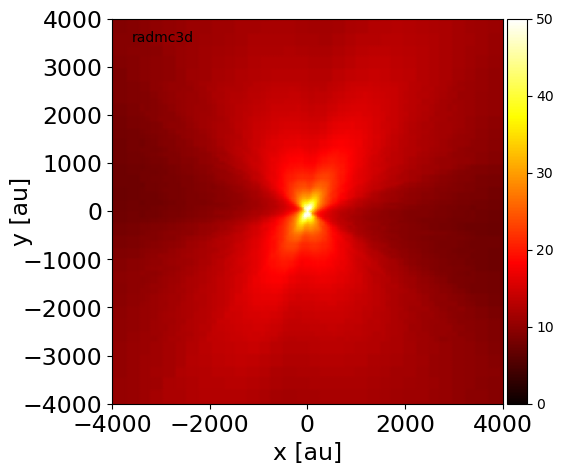

In [10]:
temperature2D(path=path, temp=temp, ext=ext_t, size=size/autocm, nx=nx, ny=ny, nz=nz, res=res, mid=150, vmin=0, vmax=50, save=False, savename='temperature2D.inp')

In [11]:
from astropy.io import fits
path_ilseung = '/data/pebbles/scratch/ilseung/6.0e+06/'

In [12]:
temp_ilseung = fits.getdata(path_ilseung + 'input_midplane_3d.fits.gz')[2]

In [13]:
temp_ilseung.shape

(301, 301, 301)

Text(0.05, 0.95, 'polaris')

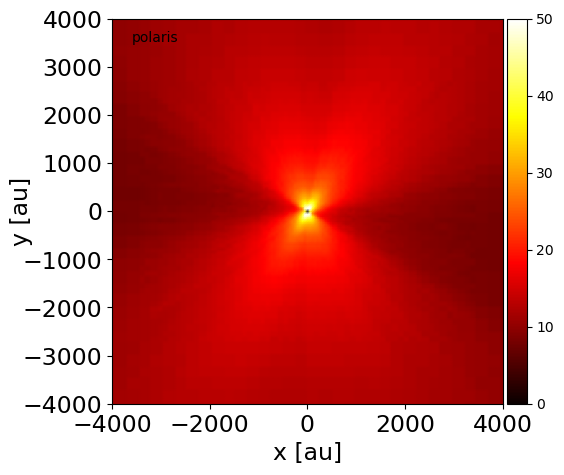

In [12]:

x=z=y=np.linspace(-size/autocm, size/autocm, nx)
temp = np.reshape(temp, (nx, ny, nz)) # reshape the density structure.
xx, yy = np.meshgrid(x, y)# create grid for figure


fig = plt.figure(figsize=(6, 5.))
ax = fig.add_subplot(111)
plt.xlabel(r'x [au]', fontsize = 17)
plt.ylabel(r'y [au]', fontsize = 17, labelpad=-7.4)

ax.set_xlim(-4000, 4000)
ax.set_ylim(-4000, 4000)
ax.tick_params(labelsize=17)
t = plt.pcolormesh(z, x, temp_ilseung[:, 150, :], cmap='hot', shading='gouraud', vmin=0, vmax=50)
clr = plt.colorbar(t, pad=0.01)
ax.text(0.05, 0.95, 'polaris', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)

In [13]:
np.max(temp_ilseung[:, 150, :])

63.87285232543945

In [14]:
coltemp = np.sum(temp, axis=1)
coltemp_ilseung = np.sum(temp_ilseung, axis=1)
diff_percent = 100*(coltemp_ilseung[:, :]-coltemp[:, :])/coltemp_ilseung[:,  :]
np.max(diff_percent)

9.60016269004875

Text(0.05, 0.95, 'polaris - radmc3d (%)')

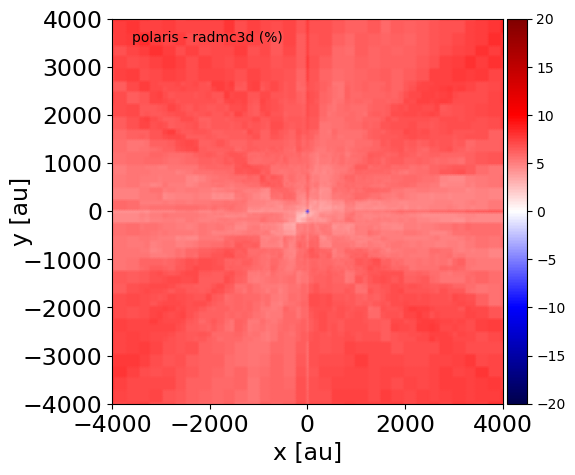

In [16]:
x=z=y=np.linspace(-size/autocm, size/autocm, nx)
temp = np.reshape(temp, (nx, ny, nz)) # reshape the density structure.
xx, yy = np.meshgrid(x, y)# create grid for figure


fig = plt.figure(figsize=(6, 5.))
ax = fig.add_subplot(111)
plt.xlabel(r'x [au]', fontsize = 17)
plt.ylabel(r'y [au]', fontsize = 17, labelpad=-7.4)

ax.set_xlim(-4000, 4000)
ax.set_ylim(-4000, 4000)
ax.tick_params(labelsize=17)
t = plt.pcolormesh(z, x, 100*(coltemp_ilseung[:, :]-coltemp[:, :])/coltemp_ilseung[:,  :], cmap='seismic', shading='gouraud', vmin=-20, vmax=20)
clr = plt.colorbar(t, pad=0.01)
ax.text(0.05, 0.95, 'polaris - radmc3d (%)', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)


Text(0.05, 0.95, 'polaris - radmc3d (%)')

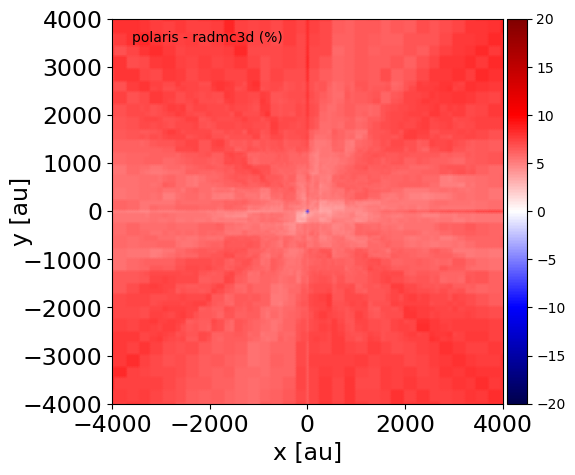

In [15]:
x=z=y=np.linspace(-size/autocm, size/autocm, nx)
temp = np.reshape(temp, (nx, ny, nz)) # reshape the density structure.
xx, yy = np.meshgrid(x, y)# create grid for figure


fig = plt.figure(figsize=(6, 5.))
ax = fig.add_subplot(111)
plt.xlabel(r'x [au]', fontsize = 17)
plt.ylabel(r'y [au]', fontsize = 17, labelpad=-7.4)

ax.set_xlim(-4000, 4000)
ax.set_ylim(-4000, 4000)
ax.tick_params(labelsize=17)
t = plt.pcolormesh(z, x, 100*(coltemp_ilseung[:, :]-coltemp[:, :])/coltemp_ilseung[:,  :], cmap='seismic', shading='gouraud', vmin=-20, vmax=20)
clr = plt.colorbar(t, pad=0.01)
ax.text(0.05, 0.95, 'polaris - radmc3d (%)', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)

In [23]:
lam = np.logspace(np.log10(0.27), np.log10(3000), 200)
for il in lam:
    print(il)

0.27
0.2829399052836239
0.2964999629700225
0.3107098942197636
0.32560084459712857
0.34120545233547966
0.35755791987428387
0.37469408882459065
0.39265151852727204
0.41146956837621274
0.43118948408688607
0.45185448809940076
0.47350987431416597
0.4962031073678177
0.5199839266670008
0.5449044554080297
0.57101931482138
0.5983857438914114
0.6270637248137287
0.6571161144651586
0.6886087821744998
0.7216107540960169
0.7561943645021165
0.7924354143268112
0.8304133373074711
0.8702113740890146
0.9119167546721407
0.9556208896055006
1.0014195703408622
1.0494131791904107
1.0997069093463756
1.1524109954452235
1.2076409551817713
1.265517842502798
1.3261685129351029
1.3897259016295642
1.456329314730621
1.5261247347098035
1.599265140332546
1.6759108419596
1.7562298329179544
1.8403981577114097
1.9286002978778598
2.0210295763390023
2.11788858112874
2.2193896094290158
2.3257551328863144
2.437218285228725
2.55402337325234
2.6764264122969585
2.8046956873847813
2.939112341251994
3.079970990562108
3.22758037165